<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from itertools import product
from tqdm import tqdm_notebook

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=0)

<AxesSubplot:xlabel='datetime'>

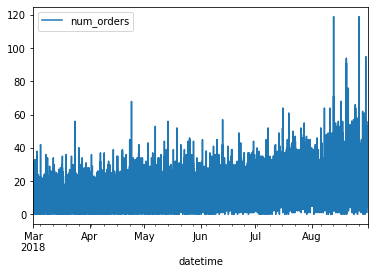

In [3]:
df.plot()

**Из данного графика ничего сильно не понятно, поэтому стоит ресемлировать данные по часу таким образом сократить кол-во наблюдений**

In [4]:
df_resample = df.resample('1H').mean()

In [5]:
df_resample = df.resample('1H').sum()

In [88]:
df_resample

,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN
2018-03-01 02:00:00,71,3,2,85.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,NaN
...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,168.041667


## Анализ

Чтобы проанализировать данные выполним декомпозицию данных. 

In [8]:
d = seasonal_decompose(df_resample)

In [9]:
d.trend

datetime
2018-03-01 00:00:00   NaN
2018-03-01 01:00:00   NaN
2018-03-01 02:00:00   NaN
2018-03-01 03:00:00   NaN
2018-03-01 04:00:00   NaN
                       ..
2018-08-31 19:00:00   NaN
2018-08-31 20:00:00   NaN
2018-08-31 21:00:00   NaN
2018-08-31 22:00:00   NaN
2018-08-31 23:00:00   NaN
Freq: H, Name: trend, Length: 4416, dtype: float64

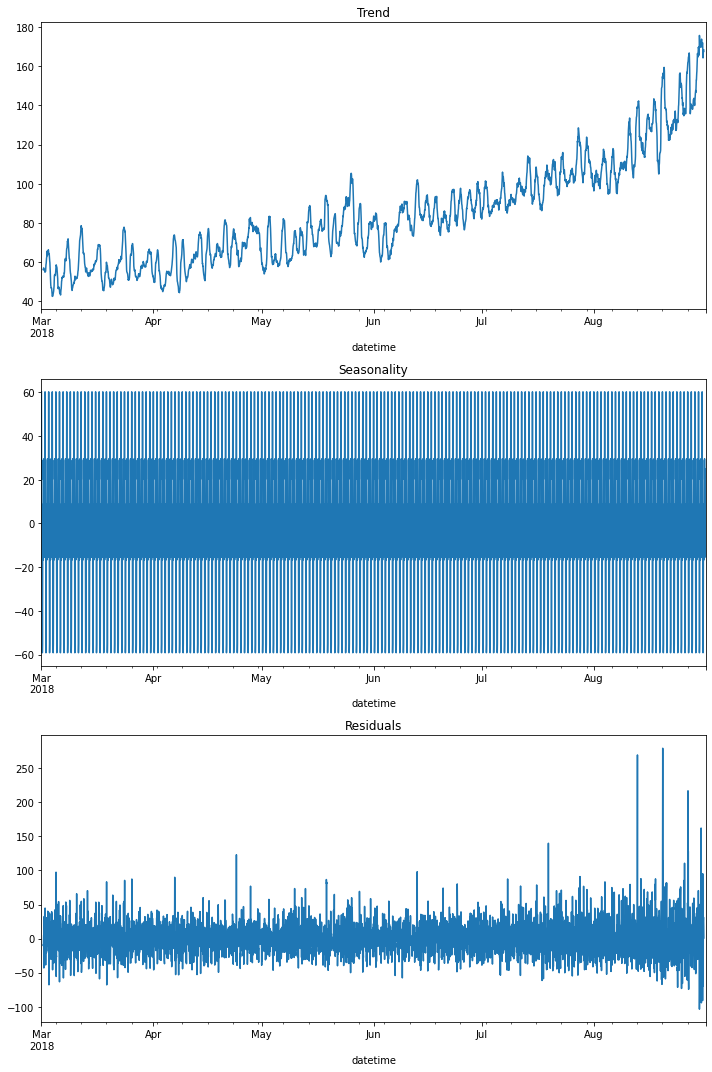

In [10]:
plt.figure(figsize=(10,15))
plt.subplot(311)
d.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
# < напишите код здесь >
d.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
# < напишите код здесь >
d.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Рассмотрим получше на сезонность**

<AxesSubplot:xlabel='datetime'>

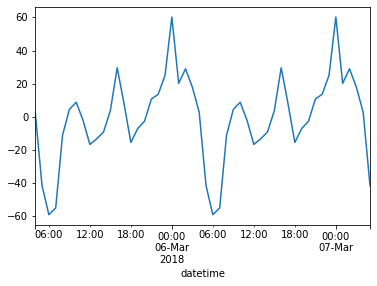

In [11]:
d.seasonal.iloc[100:150].plot()

<AxesSubplot:xlabel='datetime'>

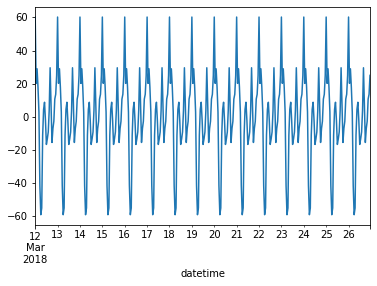

In [12]:
d.seasonal['2018-03-12':'2018-03-26'].plot()

<AxesSubplot:xlabel='datetime'>

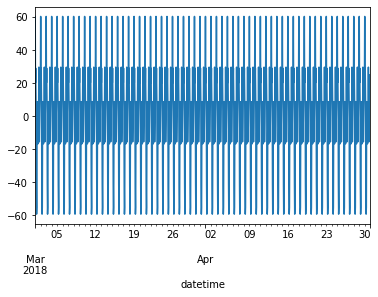

In [13]:
d.seasonal['2018-03':'2018-04'].plot()

**Видно что присутствует `ежедневная сезонность` с возникающими пиками возникающие достигающие пиков в 00:00 и около 17:00. Рассмотрим данные за неделю с 2018-03-12 : 2018-03-18, а также за две недели** 

<AxesSubplot:xlabel='datetime'>

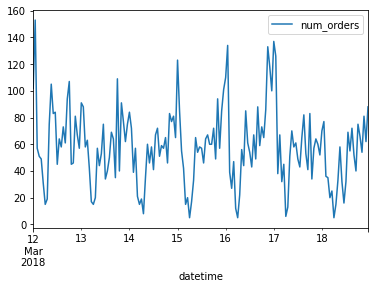

In [14]:
df_resample['2018-03-12':'2018-03-18'].plot()

<AxesSubplot:xlabel='datetime'>

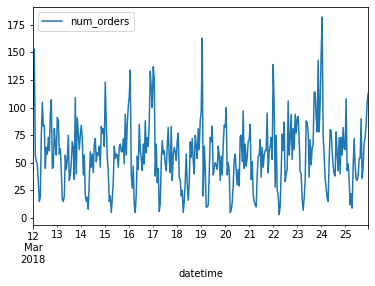

In [15]:
df_resample['2018-03-12':'2018-03-25'].plot()

<AxesSubplot:xlabel='datetime'>

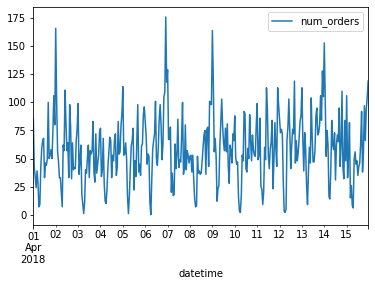

In [16]:
df_resample['2018-04-01':'2018-04-15'].plot()

<AxesSubplot:xlabel='datetime'>

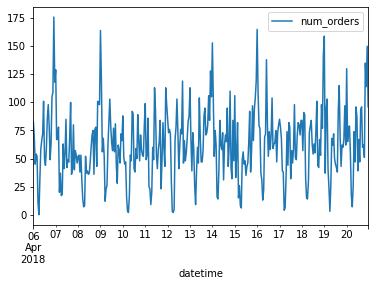

In [17]:
df_resample['2018-04-06':'2018-04-20'].plot()

# **Общий вывод**

Видно что присутсвует тенденция к росту кол-ва заказов такси, также наблюдается отчётливая сезонность в данных

По нашим данным  можно скзазать что присутсвует внутрисуточная сезонность потому что видно что есть пики возникающие в различные периоды дня, а вот присутвие остальным видов сезонности как мне кажется отсутсвует<br>


## Обучение

Сделает фичи для наших данных чтобы мы могли обучить модель

In [18]:
df_resample['num_orders']

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 4416, dtype: int64

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # < напишите код здесь >
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # < напишите код здесь >
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [22]:
make_features(df_resample, 1, 24)

In [23]:
train, oth = train_test_split(df_resample, test_size=0.2, shuffle=False)

In [24]:
test, valid = train_test_split(oth, test_size = 0.5, shuffle=False)

In [25]:
features_train = train.drop(columns='num_orders', axis=1)
target_train = train['num_orders']

In [26]:
features_test = test.drop(columns='num_orders', axis=1)
target_test = test['num_orders']

In [27]:
features_valid = valid.drop(columns='num_orders', axis=1)
target_valid = valid['num_orders']

In [28]:
features_train

,dayofweek,hour,lag_1,rolling_mean
datetime,,,,
2018-03-01 00:00:00,3,0,NaN,NaN
2018-03-01 01:00:00,3,1,124.0,NaN
2018-03-01 02:00:00,3,2,85.0,NaN
2018-03-01 03:00:00,3,3,71.0,NaN
2018-03-01 04:00:00,3,4,66.0,NaN
...,...,...,...,...
2018-07-25 23:00:00,2,23,84.0,103.625000
2018-07-26 00:00:00,3,0,138.0,104.791667
2018-07-26 01:00:00,3,1,149.0,104.291667


In [29]:
model = CatBoostRegressor(iterations=2000, learning_rate=0.05, depth=10, loss_function = 'MAE', eval_metric = 'RMSE')

In [30]:
model.fit(features_train, target_train, use_best_model=True, silent=False, eval_set=(features_valid, target_valid))

0:	learn: 35.0324164	test: 88.1823770	best: 88.1823770 (0)	total: 53.7ms	remaining: 1m 47s
1:	learn: 34.1893572	test: 86.6582639	best: 86.6582639 (1)	total: 58.2ms	remaining: 58.1s
2:	learn: 33.3769515	test: 85.6374756	best: 85.6374756 (2)	total: 62.9ms	remaining: 41.9s
3:	learn: 32.7554063	test: 84.7693273	best: 84.7693273 (3)	total: 67.2ms	remaining: 33.6s
4:	learn: 32.0432226	test: 83.7423332	best: 83.7423332 (4)	total: 71.6ms	remaining: 28.6s
5:	learn: 31.3426775	test: 82.9277126	best: 82.9277126 (5)	total: 75.8ms	remaining: 25.2s
6:	learn: 30.6266883	test: 82.0169155	best: 82.0169155 (6)	total: 81.6ms	remaining: 23.2s
7:	learn: 30.0218440	test: 80.9812515	best: 80.9812515 (7)	total: 86.1ms	remaining: 21.4s
8:	learn: 29.4832697	test: 80.1877256	best: 80.1877256 (8)	total: 90.1ms	remaining: 19.9s
9:	learn: 28.9873142	test: 79.4440277	best: 79.4440277 (9)	total: 94.3ms	remaining: 18.8s
10:	learn: 28.4901291	test: 78.7072191	best: 78.7072191 (10)	total: 98.5ms	remaining: 17.8s
11:	lea

In [31]:
mse_catboost = mean_squared_error(target_test, model.predict(features_test))
rmse_catboost = mse_catboost ** 0.5

In [32]:
rmse_catboost

31.2411862370683

**Проверим вторую модель на наших данных**

In [33]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    "num_iterations": 1000,
    "n_estimators": 10000
}


In [34]:
lgb_train = lgb.Dataset(features_train, target_train)
lgb_eval = lgb.Dataset(features_test, target_test, reference=lgb_train)

In [35]:
start_time = time.time()
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)
lgbm_exec_time = time.time() - start_time

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's l2: 3224.37	valid_0's l1: 43.0618
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 3074.21	valid_0's l1: 41.8686
[3]	valid_0's l2: 2939.24	valid_0's l1: 40.7447
[4]	valid_0's l2: 2809	valid_0's l1: 39.6653
[5]	valid_0's l2: 2701.3	valid_0's l1: 38.728
[6]	valid_0's l2: 2594.85	valid_0's l1: 37.7974
[7]	valid_0's l2: 2493.62	valid_0's l1: 36.8834
[8]	valid_0's l2: 2401.76	valid_0's l1: 36.0401
[9]	valid_0's l2: 2323.3	valid_0's l1: 35.3037
[10]	valid_0's l2: 2252.74	valid_0's l1: 34.6239
[11]	valid_0's l2: 2168.65	valid_0's l1: 33.7898
[12]	valid_0's l2: 2099.94	valid_0's l1: 33.1401
[13]	valid_0's l2: 2034.83	valid_0's l1: 32.5158
[14]	valid_0's l2: 1966.52	valid_0's l1: 31.8249
[15]	valid_0's l2: 1908.12	valid_0's l1: 31.2591
[16]	valid_0's l2: 1854.82	valid_0's l1: 30.7416
[17]	v

/home/ramen/anaconda3/envs/ml/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ramen/anaconda3/envs/ml/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


In [36]:
y_pred = gbm.predict(features_test, num_iteration=gbm.best_iteration)

In [37]:
mse_lgbm = mean_squared_error(target_test, y_pred)
rmse_lgbm = mse_lgbm ** 0.5
rmse_lgbm

31.580002859929774

**Теперь запустим модель ARIMA для наших данных**

In [38]:
df_resample

,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN
2018-03-01 02:00:00,71,3,2,85.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,NaN
...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,168.041667


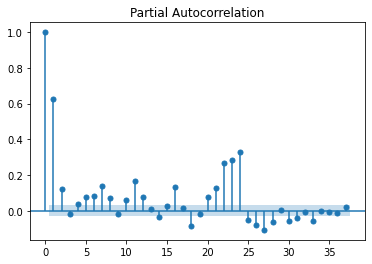

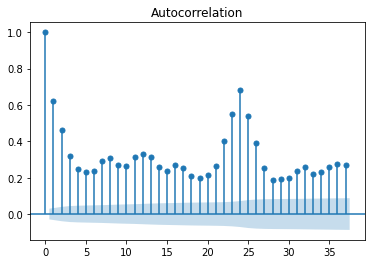

In [39]:
plot_pacf(df_resample['num_orders']);
plot_acf(df_resample['num_orders']);

**По характеру полученных графиков можно заметить что данные скорее похожи на стационарные, при этом видны пики на 24 лаге, возможно что это некая `"месячная корреляция"` данных?**

**Проверим на стационарность тестом Дикей-Фулера**

In [40]:
ad_fuller_result = adfuller(df_resample['num_orders'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.068924289027945
p-value: 0.028940051402613794


**p-value < 0.05 => Отклоняем H0 о нестационарности, следовательно приводить к стационарной форме для проведения теста не требуется**

**Затем с помощью Akaike’s Information Criterion (AIC) беремерём все значения p,d,q, чтобы найти модель с наименьшим AIC**

In [41]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [42]:
ps = range(22, 26, 1)
d = 1
qs = range(22, 26, 1)

In [43]:
parameters = product(ps, qs)
parameters_list = list(parameters)

In [62]:
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=df_resample['num_orders'])
result_df

/tmp/ipykernel_13731/1906400999.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/16 [00:00<?, ?it/s]

/home/ramen/anaconda3/envs/ml/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ramen/anaconda3/envs/ml/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ramen/anaconda3/envs/ml/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ramen/anaconda3/envs/ml/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home

,"(p, d, q)",AIC
0,"(24, 1, 25)",41025.180989
1,"(23, 1, 25)",41145.955829
2,"(23, 1, 24)",41166.401478
3,"(25, 1, 25)",41190.395670
4,"(24, 1, 24)",41230.107846
5,"(25, 1, 24)",41240.637079
6,"(23, 1, 23)",41272.479610
7,"(22, 1, 24)",41273.487769
8,"(22, 1, 23)",41273.955297
9,"(22, 1, 25)",41306.217839


In [63]:
result_df.iloc[0,0]

(24, 1, 25)

In [64]:
result_df.iloc[result_df['AIC'].idxmin()]

(p, d, q)     (24, 1, 25)
AIC          41025.180989
Name: 0, dtype: object

In [65]:
train, test = train_test_split(df_resample, test_size=0.1, shuffle=False)

In [69]:
best_model = SARIMAX(df_resample['num_orders'], order=(24,1,25)).fit()
print(best_model.summary())

/home/ramen/anaconda3/envs/ml/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ramen/anaconda3/envs/ml/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ramen/anaconda3/envs/ml/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             num_orders   No. Observations:                 4416
Model:             SARIMAX(24, 1, 25)   Log Likelihood              -20462.590
Date:                Mon, 30 Aug 2021   AIC                          41025.181
Time:                        20:26:58   BIC                          41344.819
Sample:                    03-01-2018   HQIC                         41137.918
                         - 08-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4952      0.048    -10.344      0.000      -0.589      -0.401
ar.L2         -0.3021      0.061     -4.963      0.000      -0.421      -0.183
ar.L3         -0.0378      0.058     -0.649      0.5

In [71]:
best_model.resid

datetime
2018-03-01 00:00:00    124.000000
2018-03-01 01:00:00    -38.933381
2018-03-01 02:00:00    -29.368233
2018-03-01 03:00:00    -20.248811
2018-03-01 04:00:00    -37.060819
                          ...    
2018-08-31 19:00:00     -6.758541
2018-08-31 20:00:00      3.153427
2018-08-31 21:00:00    -34.497368
2018-08-31 22:00:00     42.954502
2018-08-31 23:00:00     -4.633884
Freq: H, Length: 4416, dtype: float64

In [72]:
ljung_box, p_value = acorr_ljungbox(best_model.resid)

print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-value: {p_value[:10]}')

Ljung-Box test: [ 0.92525821  2.38767934  3.86843313  4.4440916  13.16386321 14.52680357
 19.02116097 19.16211236 19.63995907 20.90511733]
p-value: [0.33609811 0.30305539 0.27602593 0.34922834 0.02189064 0.02427428
 0.00812131 0.0140163  0.0202691  0.02176499]


/home/ramen/anaconda3/envs/ml/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "
/home/ramen/anaconda3/envs/ml/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


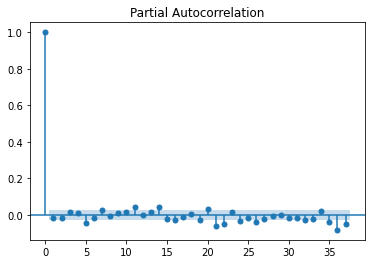

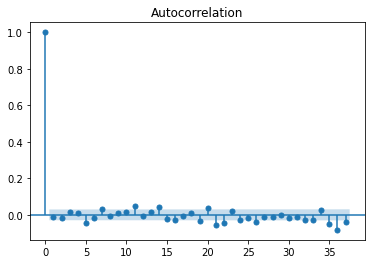

In [73]:
plot_pacf(best_model.resid);
plot_acf(best_model.resid);

In [74]:
df_resample.iloc[4300:4401]['num_orders']

datetime
2018-08-27 04:00:00    295
2018-08-27 05:00:00     62
2018-08-27 06:00:00     31
2018-08-27 07:00:00     37
2018-08-27 08:00:00    131
                      ... 
2018-08-31 04:00:00    268
2018-08-31 05:00:00     78
2018-08-31 06:00:00     35
2018-08-31 07:00:00     46
2018-08-31 08:00:00    182
Freq: H, Name: num_orders, Length: 101, dtype: int64

In [75]:
best_model.predict(4300,4400)

datetime
2018-08-27 04:00:00    180.674410
2018-08-27 05:00:00    135.421657
2018-08-27 06:00:00     92.007174
2018-08-27 07:00:00     77.599996
2018-08-27 08:00:00    121.925176
                          ...    
2018-08-31 04:00:00    150.902078
2018-08-31 05:00:00    114.193507
2018-08-31 06:00:00     76.027123
2018-08-31 07:00:00     66.283948
2018-08-31 08:00:00    133.298965
Freq: H, Name: predicted_mean, Length: 101, dtype: float64

In [76]:
target_test.index.day

Int64Index([26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
            ...
            13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
           dtype='int64', name='datetime', length=442)

In [77]:
a = mean_squared_error(df_resample.iloc[4300:4401]['num_orders'], best_model.predict(4300,4400))

In [78]:
a ** 0.5

41.664622933666394

## Тестирование

**Первая модель**

In [107]:
list_of_tuples = list(zip(target_test,model.predict(features_test)))

In [111]:
model1_data = pd.DataFrame(list_of_tuples,
                  columns = ['true', 'predict'], index = target_test.index)

<AxesSubplot:title={'center':'Результат Catboost(7дней)'}, xlabel='Дата и время', ylabel='Число заказов'>

<Figure size 720x1080 with 0 Axes>

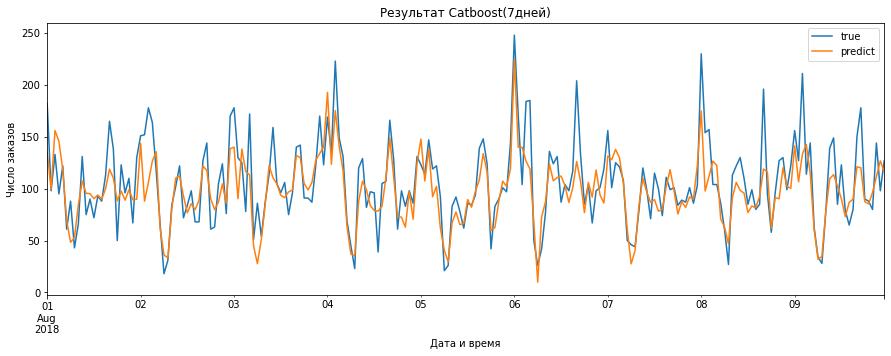

In [182]:
plt.figure(figsize=(10,15))
model1_data.loc['2018-08-01':'2018-08-09'].plot(figsize=(15,5), ylabel='Число заказов', title='Результат Catboost(7дней)', xlabel = 'Дата и время')

**Вторая модель**

In [118]:
y_pred = gbm.predict(features_test, num_iteration=gbm.best_iteration)

In [119]:
list_of_tuples = list(zip(target_test,y_pred))

In [120]:
model2_data = pd.DataFrame(list_of_tuples,
                  columns = ['true', 'predict'], index = target_test.index)

<AxesSubplot:title={'center':'Результат LGBM(7 дней)'}, xlabel='Дата и время', ylabel='Число заказов'>

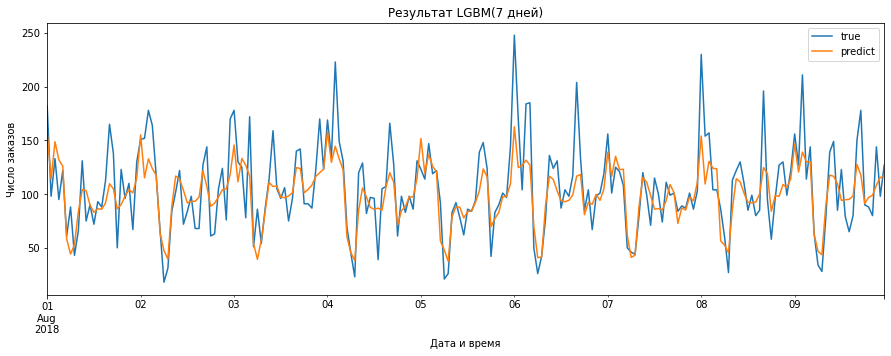

In [181]:
model2_data.loc['2018-08-01':'2018-08-09'].plot(figsize=(15,5), ylabel='Число заказов', title='Результат LGBM(7 дней)', xlabel = 'Дата и время')

**ARIMA**

In [139]:
best_model.predict(start = 1000, end = 1300)

datetime
2018-04-11 16:00:00     87.632071
2018-04-11 17:00:00     58.073082
2018-04-11 18:00:00     47.974430
2018-04-11 19:00:00     58.466596
2018-04-11 20:00:00     59.503865
                          ...    
2018-04-24 00:00:00    105.560863
2018-04-24 01:00:00     98.844027
2018-04-24 02:00:00    102.118580
2018-04-24 03:00:00     80.999251
2018-04-24 04:00:00     55.622840
Freq: H, Name: predicted_mean, Length: 301, dtype: float64

In [140]:
df_resample.iloc[1000:1301]

,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-04-11 16:00:00,84,2,16,65.0,58.833333
2018-04-11 17:00:00,23,2,17,84.0,58.625000
2018-04-11 18:00:00,49,2,18,23.0,56.833333
2018-04-11 19:00:00,82,2,19,49.0,56.875000
2018-04-11 20:00:00,60,2,20,82.0,57.333333
...,...,...,...,...,...
2018-04-24 00:00:00,253,1,0,60.0,70.208333
2018-04-24 01:00:00,77,1,1,253.0,74.625000
2018-04-24 02:00:00,83,1,2,77.0,74.750000


In [149]:
list_of_tuples = list(zip(df_resample.iloc[1000:1301]['num_orders'], best_model.predict(start = 1000, end = 1300)))

In [152]:
model3_data = pd.DataFrame(list_of_tuples,
                  columns = ['true', 'predict'], index = df_resample.iloc[1000:1301].index)

In [153]:
model3_data

,true,predict
datetime,,
2018-04-11 16:00:00,84,87.632071
2018-04-11 17:00:00,23,58.073082
2018-04-11 18:00:00,49,47.974430
2018-04-11 19:00:00,82,58.466596
2018-04-11 20:00:00,60,59.503865
...,...,...
2018-04-24 00:00:00,253,105.560863
2018-04-24 01:00:00,77,98.844027
2018-04-24 02:00:00,83,102.118580


<AxesSubplot:title={'center':'Результат ARIMA (14 дней)'}, xlabel='Дата и время', ylabel='Число заказов'>

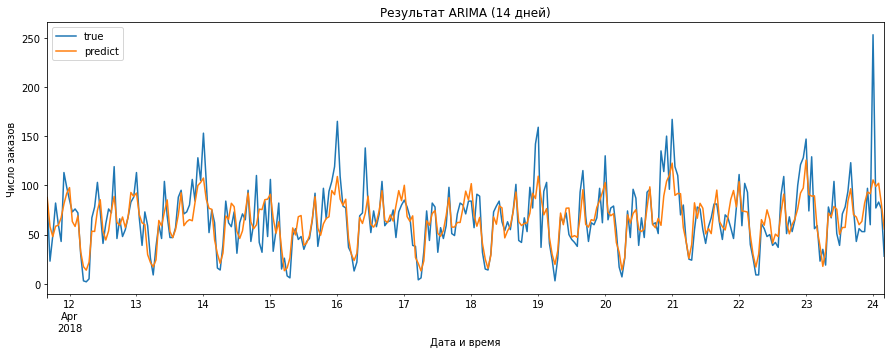

In [180]:
model3_data.plot(figsize=(15,5), ylabel='Число заказов', title='Результат ARIMA (14 дней)', xlabel = 'Дата и время')

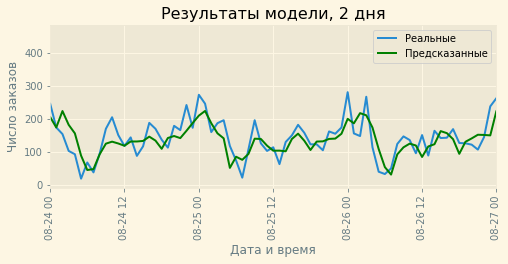